Imports

In [35]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, MaxPooling1D, Conv1D, Embedding
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [36]:
!wget -nc https://lazyprogrammer.me/course_files/spam.csv

File ‘spam.csv’ already there; not retrieving.



In [37]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

Drop unnecessary columns

In [38]:
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [39]:
df.columns = ['labels', 'data']

In [40]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


Create binary labels

In [41]:
df['b_labels'] = df.labels.map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

Split the data

In [42]:
df_train, df_test, Y_train, Y_test = train_test_split(df['data'], Y, test_size=0.33)

Convert sentences te sequences

In [43]:
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

get word -> integer mapping

In [44]:
word2idx = tokenizer.word_index
V = len(word2idx)
print(f"Found {V} unique tokens.")

Found 7209 unique tokens.


Pad sequences so that we get N x T matrix

In [45]:
data_train = pad_sequences(sequences_train)
print("Shape of data train tensor:", data_train.shape)

Shape of data train tensor: (3733, 121)


Get sequence length

In [46]:
T = data_train.shape[1]

In [47]:
data_test = pad_sequences(sequences_test, maxlen=T)
print("Shape of data test tensor:", data_test.shape)

Shape of data test tensor: (1839, 121)


Create the model

We get to choose embedding dimensionality (D)

Note: we actually want to the size of the embedding to (V + 1) x D

because the first index start from 1 and not 0

Thus, if the final index of the embedding maxtrix is V, then it actually must have size V + 1

In [48]:
D = 20

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

Compile and fit


In [49]:
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

r = model.fit(
    data_train, Y_train,
    validation_data=(data_test, Y_test),
    epochs=5
)

Epoch 1/5
117/117 [==============================] - 5s 28ms/step - loss: 0.4077 - accuracy: 0.8655 - val_loss: 0.3330 - val_accuracy: 0.8668
Epoch 2/5
117/117 [==============================] - 2s 17ms/step - loss: 0.1429 - accuracy: 0.9472 - val_loss: 0.1161 - val_accuracy: 0.9766
Epoch 3/5
117/117 [==============================] - 2s 16ms/step - loss: 0.0307 - accuracy: 0.9909 - val_loss: 0.0897 - val_accuracy: 0.9815
Epoch 4/5
117/117 [==============================] - 2s 16ms/step - loss: 0.0164 - accuracy: 0.9954 - val_loss: 0.0938 - val_accuracy: 0.9782
Epoch 5/5
117/117 [==============================] - 2s 17ms/step - loss: 0.0106 - accuracy: 0.9973 - val_loss: 0.1154 - val_accuracy: 0.9831


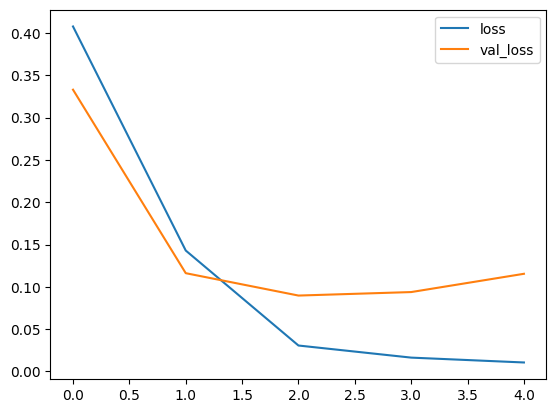

In [50]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend();

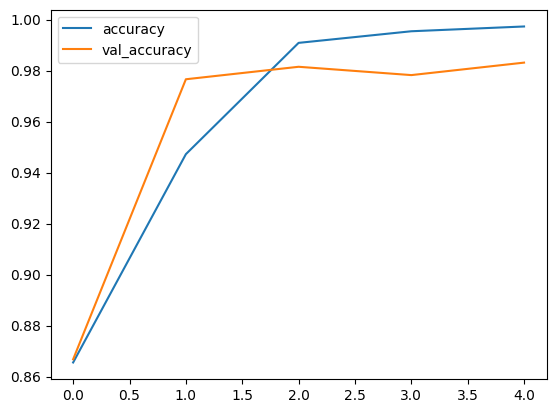

In [51]:
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend();

In [53]:
p_test = model.predict(data_test).argmax(axis=1)


58/58 [==============================] - 0s 5ms/step


Show some misclassified examples

In [62]:
misclassified_idx = np.where(p_test != Y_test)[0]
i = np.random.choice(misclassified_idx)
print("Text:", df_test.iloc[i])
print("True label:", Y_test[i], "Predicted:", p_test[i])


Text: As one of our registered subscribers u can enter the draw 4 a 100 G.B. gift voucher by replying with ENTER. To unsubscribe text STOP
True label: 1 Predicted: 0
